# Magic The Gathering Bloomburrow Limited Analysis

### Scraping Cards to DataFrame

In [2]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import requests
import time
from bs4 import BeautifulSoup as bs

import pickle

import re

In [3]:
# Dictionary of Data

pages = []

data = {'name':[],
        'rarity':[],
        'mana_cost':[],
        'type':[],
        'ctypes':[],
        'text':[],
        'power':[],
        'toughness':[]}

In [4]:
# Scrape Card Pages

# headers = {'User-Agent': 
#            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'}

url1 = 'https://scryfall.com/search?as=grid&order=name&'
url2 = 'q=%28game%3Apaper%29+legal%3Astandard+set%3Ablb&unique=cards'

for i in range(1,6):
    urlfill = ''
    if i > 1:
        urlfill = f'page={i}&'
    r_blb = requests.get(url1+urlfill+url2)
    if (r_blb.status_code == 200):
        blb = bs(r_blb.content)
        pages.append(blb)
    else:
        print(f'Error scraping page {i}.')
    time.sleep(1)

#### Example Page
<img src='assets/page1.png'>

In [5]:
# Scrape Card URLs

card_pages = []

for page in pages:
    cards = page.find_all(class_="card-grid-item-card")
    for card in cards:
        r_card = requests.get(card.get('href'))
        if (r_card.status_code == 200):
            c = bs(r_card.content)
            card_pages.append(c)
        else:
            cname = card.find('span').string
            print(f"Error scraping {cname}.")
        time.sleep(1)

#### Example Card Page
<img src='assets/page2.png'>

In [6]:
# Collect Card Information

for card in card_pages:
    
    data['name'].append(card.find("h1").find(class_="card-text-card-name").string.strip())
    
    data['rarity'].append(card.find(class_="prints-current-set-details").contents[0].strip().split('·')[1].strip())
    
    
    
    t = card.find(class_="card-text-type-line").string.split()
    ct = np.nan
    line = 60
    mana = np.nan
    if 'Land' not in t:
        
        m = card.find("h1").find_all("abbr")
        mana = ''
        for pip in m:
            mana += pip.string
            
        if len(t) > 1:
            line = t.index('—') 
            ct = t[line+1:]
            
    data['type'].append(t[:line])
    data['ctypes'].append(ct) 
    data['mana_cost'].append(mana)
    
    data['text'].append(' '.join(card.find(class_="card-text-oracle").stripped_strings))
    
    p = np.nan
    to = np.nan
    if 'Creature' in t:
        s = card.find(class_="card-text-stats").string.strip()
        slash = s.find('/')
        p = s[:slash]
        to = s[slash+1:]
    data['power'].append(p)
    data['toughness'].append(to)

In [3]:
# Save scraped data dictionary as pickle file.
# with open('assets/blb_data.pickle', 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Load dictionary from pickle and make into DataFrame
with open('assets/blb_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
cards_df = pd.DataFrame(data)
cards_df

,name,rarity,mana_cost,type,ctypes,text,power,toughness
0,Agate Assault,Common,{2}{R},[Sorcery],NaN,Choose one — • Agate Assault deals 4 damage to...,NaN,NaN
1,Agate-Blade Assassin,Common,{1}{B},[Creature],"[Lizard, Assassin]","Whenever Agate-Blade Assassin attacks, defendi...",1,3
2,"Alania, Divergent Storm",Rare,{3}{U}{R},"[Legendary, Creature]","[Otter, Wizard]","Whenever you cast a spell, if it’s the first i...",3,5
3,Alania's Pathmaker,Common,{3}{R},[Creature],"[Otter, Wizard]","When Alania’s Pathmaker enters, exile the top ...",4,2
4,Artist's Talent,Rare,{1}{R},[Enchantment],[Class],(Gain the next level as a sorcery to add its a...,NaN,NaN
...,...,...,...,...,...,...,...,...
274,"Wick, the Whorled Mind",Rare,{3}{B},"[Legendary, Creature]","[Rat, Warlock]",Whenever Wick or another Rat you control enter...,2,4
275,Wildfire Howl,Uncommon,{1}{R}{R},[Sorcery],NaN,Gift a card (You may promise an opponent a gif...,NaN,NaN
276,Wishing Well,Rare,{3}{U},[Artifact],NaN,{T} : Put a coin counter on Wishing Well. When...,NaN,NaN
277,"Ygra, Eater of All",Mythic Rare,{3}{B}{G},"[Legendary, Creature]","[Elemental, Cat]",Ward—Sacrifice a Food. Other creatures are Foo...,6,6


### Scraping Card Tier List
<img src='assets/page3.png'>

In [4]:
# Card Grades
url = 'https://cardgamebase.com/bloomburrow-draft-tier-list/'
header = {'User-Agent': 'Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148'}


cardgrades = {'name':[], 'grade':[]}

r_blb_grades = requests.get(url, headers=header)
if (r_blb_grades.status_code == 200):
    blb_grades = bs(r_blb_grades.content)
else:
    print(f'Error scraping Grades.')

blb_tables = blb_grades.find_all(class_="row-hover")
for table in blb_tables:
    names = table.find_all(class_='column-1')
    grades = table.find_all(class_='column-2')
    for name, grade in zip(names, grades):
        cardgrades['name'].append(name.find("a").string)
        cardgrades['grade'].append(grade.string)

In [5]:
# Joining Data
card_grades_df = pd.DataFrame(cardgrades)
cards_df = cards_df.merge(card_grades_df, on='name')
cards_df

,name,rarity,mana_cost,type,ctypes,text,power,toughness,grade
0,Agate Assault,Common,{2}{R},[Sorcery],NaN,Choose one — • Agate Assault deals 4 damage to...,NaN,NaN,C+
1,Agate-Blade Assassin,Common,{1}{B},[Creature],"[Lizard, Assassin]","Whenever Agate-Blade Assassin attacks, defendi...",1,3,C
2,"Alania, Divergent Storm",Rare,{3}{U}{R},"[Legendary, Creature]","[Otter, Wizard]","Whenever you cast a spell, if it’s the first i...",3,5,B-
3,Alania's Pathmaker,Common,{3}{R},[Creature],"[Otter, Wizard]","When Alania’s Pathmaker enters, exile the top ...",4,2,C+
4,Artist's Talent,Rare,{1}{R},[Enchantment],[Class],(Gain the next level as a sorcery to add its a...,NaN,NaN,D
...,...,...,...,...,...,...,...,...,...
256,"Wick, the Whorled Mind",Rare,{3}{B},"[Legendary, Creature]","[Rat, Warlock]",Whenever Wick or another Rat you control enter...,2,4,B+
257,Wildfire Howl,Uncommon,{1}{R}{R},[Sorcery],NaN,Gift a card (You may promise an opponent a gif...,NaN,NaN,C
258,Wishing Well,Rare,{3}{U},[Artifact],NaN,{T} : Put a coin counter on Wishing Well. When...,NaN,NaN,D+
259,"Ygra, Eater of All",Mythic Rare,{3}{B}{G},"[Legendary, Creature]","[Elemental, Cat]",Ward—Sacrifice a Food. Other creatures are Foo...,6,6,A-


In [3]:
# Save Combined DataFrame to CSV
# cards_df.to_csv('cards.csv', index=False)

# Load Combined DataFrame from CSV
cards_df = pd.read_csv('cards.csv')
cards_df

,name,rarity,mana_cost,type,ctypes,text,power,toughness,grade
0,Agate Assault,Common,{2}{R},['Sorcery'],NaN,Choose one — • Agate Assault deals 4 damage to...,NaN,NaN,C+
1,Agate-Blade Assassin,Common,{1}{B},['Creature'],"['Lizard', 'Assassin']","Whenever Agate-Blade Assassin attacks, defendi...",1,3,C
2,"Alania, Divergent Storm",Rare,{3}{U}{R},"['Legendary', 'Creature']","['Otter', 'Wizard']","Whenever you cast a spell, if it’s the first i...",3,5,B-
3,Alania's Pathmaker,Common,{3}{R},['Creature'],"['Otter', 'Wizard']","When Alania’s Pathmaker enters, exile the top ...",4,2,C+
4,Artist's Talent,Rare,{1}{R},['Enchantment'],['Class'],(Gain the next level as a sorcery to add its a...,NaN,NaN,D
...,...,...,...,...,...,...,...,...,...
256,"Wick, the Whorled Mind",Rare,{3}{B},"['Legendary', 'Creature']","['Rat', 'Warlock']",Whenever Wick or another Rat you control enter...,2,4,B+
257,Wildfire Howl,Uncommon,{1}{R}{R},['Sorcery'],NaN,Gift a card (You may promise an opponent a gif...,NaN,NaN,C
258,Wishing Well,Rare,{3}{U},['Artifact'],NaN,{T} : Put a coin counter on Wishing Well. When...,NaN,NaN,D+
259,"Ygra, Eater of All",Mythic Rare,{3}{B}{G},"['Legendary', 'Creature']","['Elemental', 'Cat']",Ward—Sacrifice a Food. Other creatures are Foo...,6,6,A-


### Data Engineering

In [4]:
# CARD INFO

# Function to determine Converted Mana Cost
def cmccalc(s):
    if pd.isna(s):
        return 0
    cmc = 0
    for c in s:
        if c == '{':
            cmc += 1
        if c == 'X':
            cmc -= 1
        if c.isnumeric():
            cmc += int(c) - 1
    return cmc

# Converted Mana Cost
cards_df['cmc'] = cards_df['mana_cost'].apply(cmccalc)

# Function to determine Card Colours
def colours(s):
    if pd.isna(s):
        return 'N'
    c = 0
    cols = ''
    for colour in ['W','B','U','R','G']:
        if s.find(colour) > -1:
            cols += f'{colour}, '
    if not cols:
        cols = 'N'
    return cols.strip(', ')

# Card Colours
cards_df['colours'] = cards_df['mana_cost'].apply(colours)

# Card Grades
grade_conversion = {'A+':6,'A':5.5,'A-':5,'B+':4.5,'B':4,'B-':3.5,'C+':3,'C':2.5,'C-':2,'D+':1.5,'D':1,'D-':0.5,'F':0}
cards_df['score'] = cards_df['grade'].apply(lambda X: grade_conversion[X] if X else np.nan)


# CARD EFFECTS

# Text Filter Functions

def textfilter(text, words):
    text = text.lower()
    for word in words:
        if text.find(word) < 0:
            return False
    return True

def regexfilter(text, expressions):
    for expression in expressions:
        filt = re.compile(expression, re.IGNORECASE)
        match = filt.search(text)
        if not match:
            return False
    return True

# Lifegain
cards_df['life'] = cards_df['text'].apply(lambda x: True if (regexfilter(x.lower(),['you gain . life']) or textfilter(x.lower(),['lifelink'])) and not textfilter(x.lower(),['gift a food']) else False)

# Creature Removal
cards_df['cremoval'] = cards_df['text'].apply(lambda x: True if (regexfilter(x,['(destroy|exile) target( nontoken|) (creature|(nonland permanent))']) or textfilter(x,['fight', 'target creature']) or textfilter(x,['deals damage equal to','target creature']) or regexfilter(x,['deals . damage to(( up to one)|) ((any target)|(target creature)|(target attacking, blocking, or tapped creature))']) or regexfilter(x,['target creature(( an opponent controls)|) gets -./-.']) or textfilter(x,['you control enchanted creature']) or textfilter(x,['loses all other card types and abilities']) or regexfilter(x,['((each player)|(target opponent)) sacrifices a creature'])) and not textfilter(x,['exile target creature you control']) else False)

# Artifact Removal, Enchantment Removal, Planeswalker Removal
cards_df['aremoval'] = cards_df['text'].apply(lambda x: True if (regexfilter(x,['(destroy|exile) target (artifact|(nonland permanent))']) or regexfilter(x,['((each player)|(target opponent)) sacrifices a(n|) ((nonland permanent)|artifact)']) or textfilter(x,['destroy all permanents'])) else False)
cards_df['eremoval'] = cards_df['text'].apply(lambda x: True if (regexfilter(x,['(destroy|exile) target.+(enchantment|(nonland permanent))']) or regexfilter(x,['((each player)|(target opponent)) (sacrifices|exiles) a(n|) ((nonland permanent)|enchantment)']) or textfilter(x,['destroy all permanents'])) else False)
cards_df['premoval'] = cards_df['text'].apply(lambda x: True if (regexfilter(x,['(destroy|exile) target.+(planeswalker|(nonland permanent))']) or regexfilter(x,['deals . damage to (any|) target.+(planeswalker|)']) or regexfilter(x,['((each player)|(target opponent)) sacrifices a ((nonland permanent)|planeswalker)'])) else False)

# Sweepers (Mass Removal)
cards_df['sweeper'] = cards_df['text'].apply(lambda x: True if (regexfilter(x,['deals . damage to each creature']) or regexfilter(x,['(exile|destroy) all (creatures|permanents)']) or regexfilter(x,['creatures get -./-. until end of turn']) or textfilter(x,['choose the same mode','sacrifices a creature'])) else False)

# Card Draw
cards_df['draw'] = cards_df['text'].apply(lambda x: True if (regexfilter(x,['draw . card']) or textfilter(x,['look at the top', 'into your hand']) or regexfilter(x,['you may play (that|those|)( card|them)'])) and not textfilter(x,['gift a card']) else False)

# Scry and Surveil
cards_df['scry'] = cards_df['text'].apply(lambda x: True if regexfilter(x,['scry .']) else False)
cards_df['surveil'] = cards_df['text'].apply(lambda x: True if regexfilter(x,['surveil .']) else False)

# Self Discard and Discard
cards_df['sdiscard'] = cards_df['text'].apply(lambda x: True if regexfilter(x,['discard(ing|) a card']) and not (textfilter(x,['ward—discard a card']) or textfilter(x,['target opponent'])) else False)
cards_df['discard'] = cards_df['text'].apply(lambda x: True if regexfilter(x,['(target|each) opponent', 'discard']) else False)

# Self Mill and Mill
cards_df['smill'] = cards_df['text'].apply(lambda x: True if regexfilter(x,['(target player |you( may |)|)mill']) else False)
cards_df['mill'] = cards_df['text'].apply(lambda x: True if regexfilter(x,['(target|each) (player|opponent) mill']) else False)

# Pump
cards_df['pump'] = cards_df['text'].apply(lambda x: True if regexfilter(x,['target creature( you control|) gets \+']) else False)

# Hand Revive and Battlefield Revive
cards_df['hrevive'] = cards_df['text'].apply(lambda x: True if textfilter(x,['graveyard to your hand']) else False)
cards_df['brevive'] = cards_df['text'].apply(lambda x: True if regexfilter(x,['(creature|permanent)','graveyard( this way|) to the battlefield']) else False)

# Creature Token
cards_df['ctoken'] = cards_df['text'].apply(lambda x: True if regexfilter(x,['create .+creature token']) and not textfilter(x,['gift a tapped fish']) else False)

# +1/+1 Counter
cards_df['1counter'] = cards_df['text'].apply(lambda x: True if textfilter(x,['+1/+1 counter']) and not textfilter(x,['supply counter']) else False)

# Counter
cards_df['counterspell'] = cards_df['text'].apply(lambda x: True if textfilter(x,['counter target']) else False)

# Bounce Self and Bounce Opponent
cards_df['sbounce'] = cards_df['text'].apply(lambda x: True if textfilter(x,['owner','hand']) and not textfilter(x,['an opponent control']) else False)
cards_df['obounce'] = cards_df['text'].apply(lambda x: True if textfilter(x,['owner','hand']) and not textfilter(x,['you control']) else False)

# Burn
cards_df['burn'] = cards_df['text'].apply(lambda x: True if (regexfilter(x,['deals( .|) damage to ((any target|(target|each) (player|opponent))|(.+controller))'])) else False)

# Evasion
cards_df['evasion'] = cards_df['text'].apply(lambda x: True if regexfilter(x,['(gains |has |)(flying|menace)']) and not regexfilter(x,['(loses|destroy target creature with) (flying|menace)']) else False)

cards_df

,name,rarity,mana_cost,type,ctypes,text,power,toughness,grade,cmc,...,pump,hrevive,brevive,ctoken,1counter,counterspell,sbounce,obounce,burn,evasion
0,Agate Assault,Common,{2}{R},['Sorcery'],NaN,Choose one — • Agate Assault deals 4 damage to...,NaN,NaN,C+,3,...,False,False,False,False,False,False,False,False,False,False
1,Agate-Blade Assassin,Common,{1}{B},['Creature'],"['Lizard', 'Assassin']","Whenever Agate-Blade Assassin attacks, defendi...",1,3,C,2,...,False,False,False,False,False,False,False,False,False,False
2,"Alania, Divergent Storm",Rare,{3}{U}{R},"['Legendary', 'Creature']","['Otter', 'Wizard']","Whenever you cast a spell, if it’s the first i...",3,5,B-,5,...,False,False,False,False,False,False,False,False,False,False
3,Alania's Pathmaker,Common,{3}{R},['Creature'],"['Otter', 'Wizard']","When Alania’s Pathmaker enters, exile the top ...",4,2,C+,4,...,False,False,False,False,False,False,False,False,False,False
4,Artist's Talent,Rare,{1}{R},['Enchantment'],['Class'],(Gain the next level as a sorcery to add its a...,NaN,NaN,D,2,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,"Wick, the Whorled Mind",Rare,{3}{B},"['Legendary', 'Creature']","['Rat', 'Warlock']",Whenever Wick or another Rat you control enter...,2,4,B+,4,...,False,False,False,True,True,False,False,False,False,False
257,Wildfire Howl,Uncommon,{1}{R}{R},['Sorcery'],NaN,Gift a card (You may promise an opponent a gif...,NaN,NaN,C,3,...,False,False,False,False,False,False,False,False,True,False
258,Wishing Well,Rare,{3}{U},['Artifact'],NaN,{T} : Put a coin counter on Wishing Well. When...,NaN,NaN,D+,4,...,False,False,False,False,False,False,False,False,False,False
259,"Ygra, Eater of All",Mythic Rare,{3}{B}{G},"['Legendary', 'Creature']","['Elemental', 'Cat']",Ward—Sacrifice a Food. Other creatures are Foo...,6,6,A-,5,...,False,False,False,False,True,False,False,False,False,False


### Plots

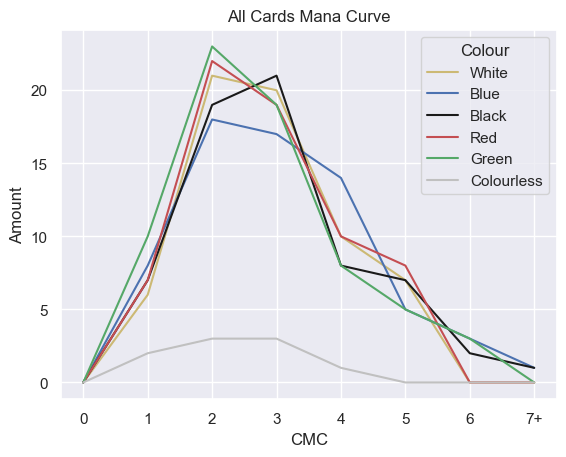

In [15]:
# Evaluating Mana Curve by Colour
colours = {'W':'White', 'U':'Blue', 'B':'Black', 'R':'Red', 'G':'Green', 'N':'Colourless'}
cmctotals = {'CMC': ['0', '1', '2', '3', '4', '5', '6', '7+']}

colour_dfs = {}
for colour in colours:
    cmctotals[colours[colour]] = []
    colour_df = cards_df.loc[((cards_df.colours.str.find('N') > -1) | (cards_df.colours.str.find(colour) > -1)) & (cards_df.type.apply(lambda X: 'Land' not in X))]
    colour_dfs[colour] = colour_df
    for i in range(7):        
        cmctotals[colours[colour]].append(len(colour_df[colour_df.cmc == i]))
    cmctotals[colours[colour]].append(len(colour_df[colour_df.cmc > 6]))
    
cmcdata = pd.DataFrame(cmctotals)
cmcmelt = pd.melt(cmcdata, ['CMC'], var_name='Colour', value_name='Amount')

palette = ['y','b','k','r','g','silver']

sns.lineplot(data=cmcmelt, x='CMC', y='Amount', hue='Colour', palette=palette).set_title('All Cards Mana Curve')
plt.show()

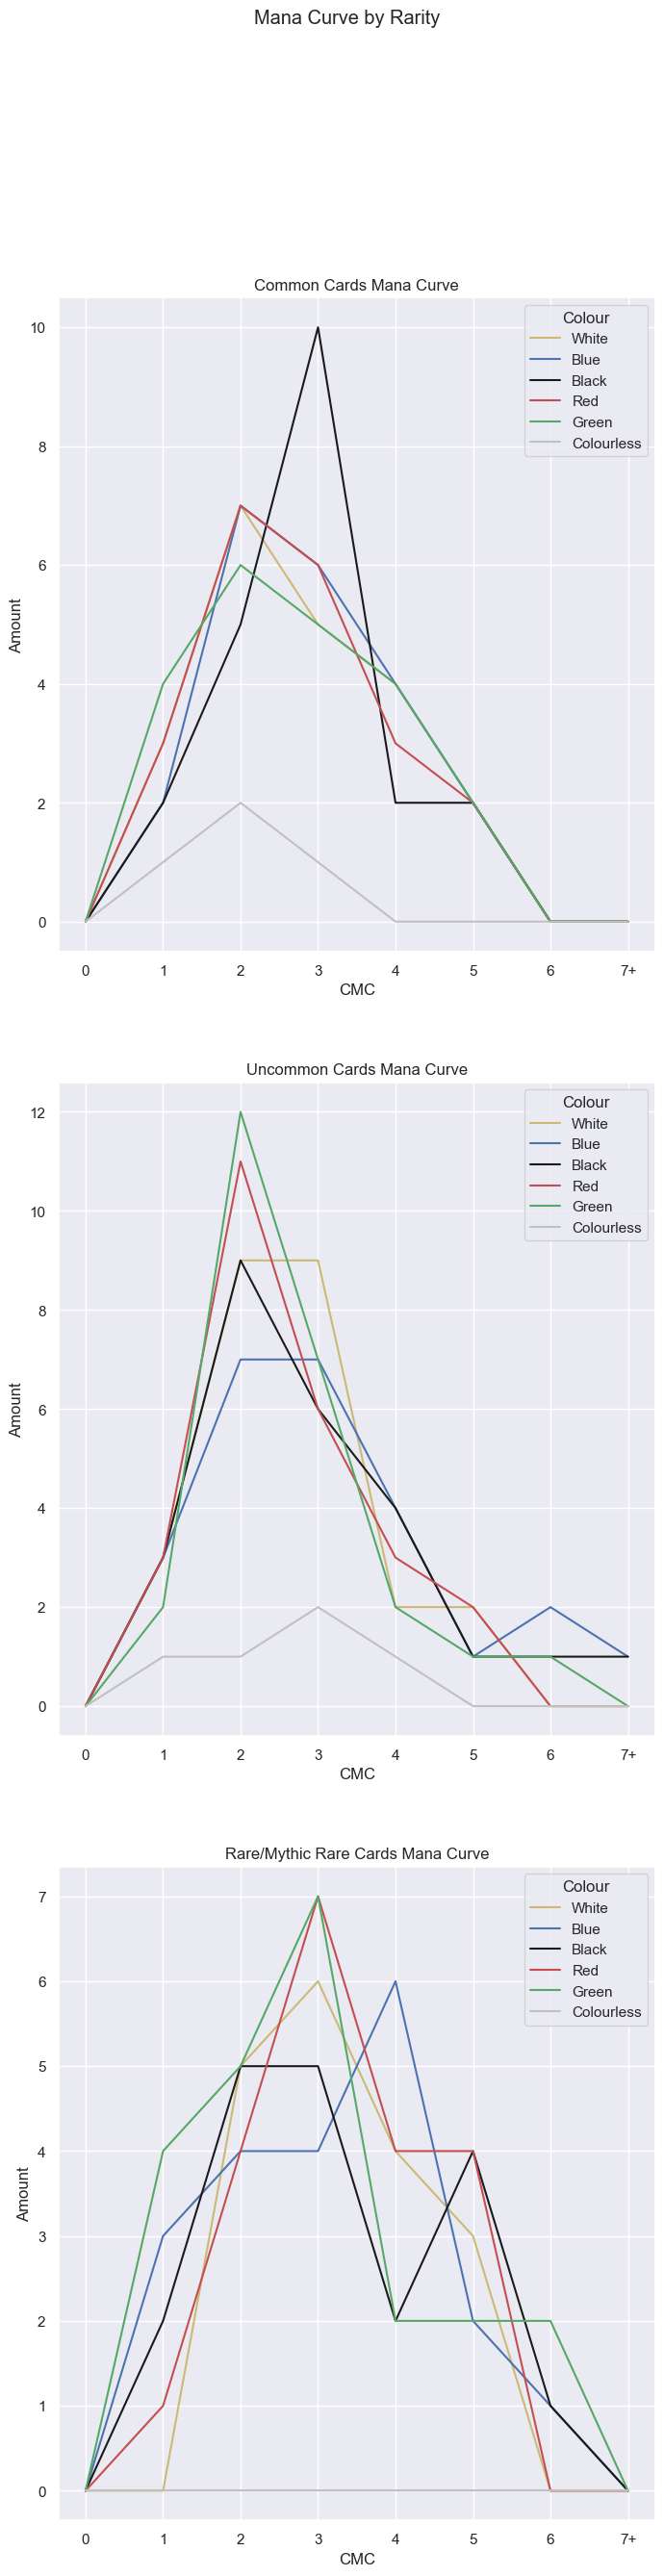

In [6]:
# Evaluating Mana Curve by Colour and Rarity
rarities = ['Common', 'Uncommon', 'Rare']

fig, ax = plt.subplots(len(rarities), figsize=(8,30))
fig.suptitle('Mana Curve by Rarity')

for i, rarity in enumerate(rarities):
    cmcrarities = {'CMC': ['0', '1', '2', '3', '4', '5', '6', '7+']}    
    for colour in colours:
        cmcrarities[colours[colour]] = []
        df = colour_dfs[colour].copy()
        temp_rarity = rarity
        if rarity == 'Rare':
            df = df.loc[df.rarity.isin([rarity, 'Mythic Rare'])]
            temp_rarity = 'Rare/Mythic Rare'
        else:
            df = df.loc[df.rarity == temp_rarity]
        for j in range(7):
            cmcrarities[colours[colour]].append(len(df[df.cmc == j]))
        cmcrarities[colours[colour]].append(len(df[df.cmc > 6]))
    raritydata = pd.DataFrame(cmcrarities)
    raritymelt = pd.melt(raritydata, ['CMC'], var_name='Colour', value_name='Amount')
    sns.lineplot(ax=ax[i], data=raritymelt, x='CMC', y='Amount', hue='Colour', palette=palette).set_title(f'{temp_rarity} Cards Mana Curve')

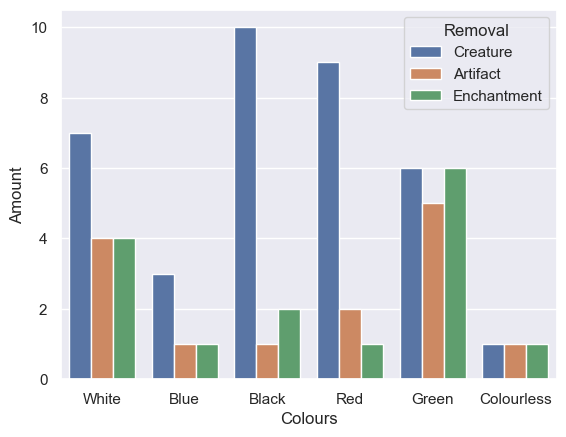

In [16]:
# Evaluating Removal by Colour and Removal Type
removal_totals = {'Colours':[x for x in colours.values()]}
removal_types = {'Creature':'cremoval','Artifact':'aremoval','Enchantment':'eremoval'}
for remtype in removal_types:
    removal_totals[remtype] = []
for colour in colours:
    for remtype in removal_types:
        removal_totals[remtype].append(colour_dfs[colour][removal_types[remtype]].sum())
rem_df = pd.DataFrame(removal_totals)
rem_melt = pd.melt(rem_df, id_vars="Colours", var_name="Removal", value_name="Amount")

sns.barplot(rem_melt, x='Colours', y='Amount', hue='Removal')
plt.show()

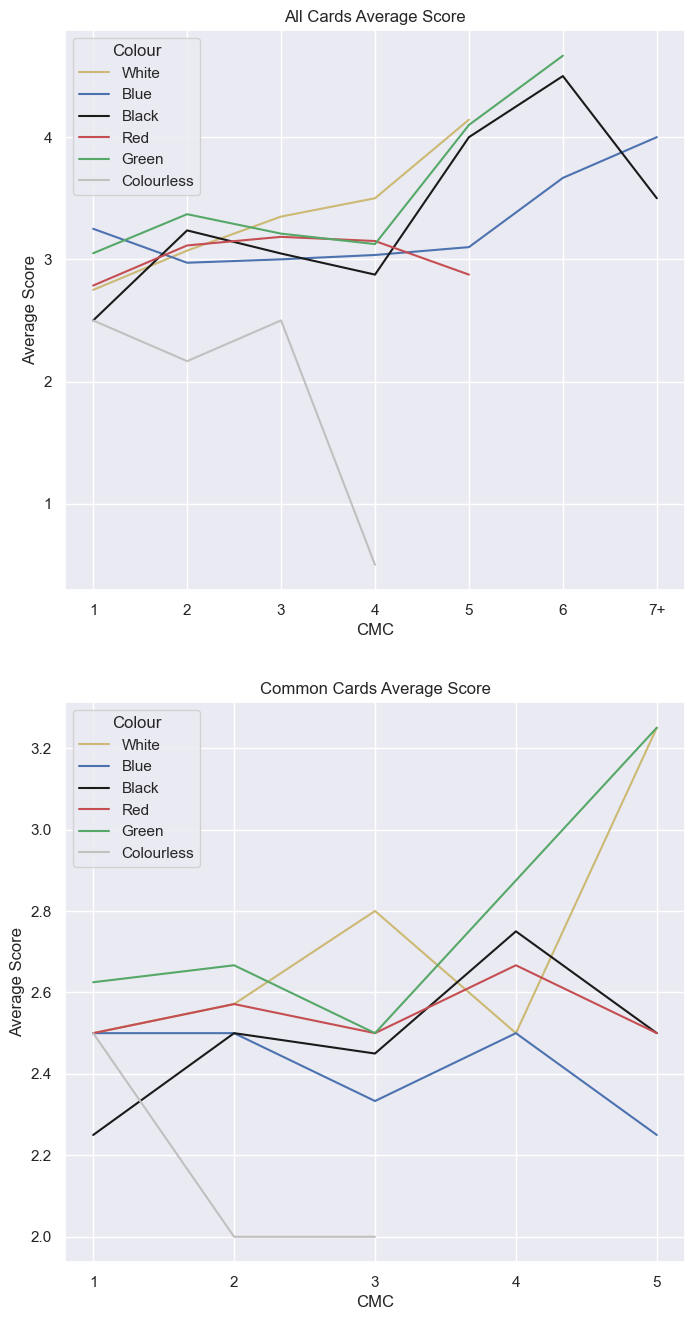

In [17]:
# Evaluating Mana Curve by Average Score and Colour for All Cards and Common Cards
cmcaves = {'CMC': ['0', '1', '2', '3', '4', '5', '6', '7+']}
comcmcaves = {'CMC': ['0', '1', '2', '3', '4', '5', '6', '7+']}

for colour in colours:
    cmcaves[colours[colour]] = []
    comcmcaves[colours[colour]] = []
    colour_df = colour_dfs[colour]
    for i in range(7):        
        cmcaves[colours[colour]].append(colour_df[colour_df.cmc == i].score.mean())
        comcmcaves[colours[colour]].append(colour_df[(colour_df.cmc == i) & (colour_df.rarity == 'Common')].score.mean())
    cmcaves[colours[colour]].append(colour_df[colour_df.cmc > 6].score.mean())
    comcmcaves[colours[colour]].append(colour_df[(colour_df.cmc > 6) & (colour_df.rarity == 'Common')].score.mean())
    
scoredata = pd.DataFrame(cmcaves)
comscoredata = pd.DataFrame(comcmcaves)
scoremelt = pd.melt(scoredata, ['CMC'], var_name='Colour', value_name='Average Score')
comscoremelt = pd.melt(comscoredata, ['CMC'], var_name='Colour', value_name='Average Score')

fig, ax = plt.subplots(2, figsize=(8,16))
sns.lineplot(ax=ax[0], data=scoremelt, x='CMC', y='Average Score', hue='Colour', palette=palette).set_title('All Cards Average Score')
sns.lineplot(ax=ax[1], data=comscoremelt, x='CMC', y='Average Score', hue='Colour', palette=palette).set_title('Common Cards Average Score')
plt.show()